<a href="https://colab.research.google.com/github/therealcyberlord/tensorflow_keras_stock_prediction/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
stock_file = open('/content/gdrive/My Drive/Data/Stock Prediction/BABA.csv', 'rb')
stock_data = pd.read_csv(stock_file)

Reads the stock data

In [0]:
stock_data.dropna(inplace=True)
stock_data.drop('Adj Close', axis=1, inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,2018-12-17,146.500000,147.940002,142.240005,143.979996,15788100
1,2018-12-18,144.279999,144.750000,140.110001,140.820007,17846600
2,2018-12-19,141.039993,141.324997,135.729996,137.139999,27657800
3,2018-12-20,135.830002,137.755005,132.910004,135.110001,24103800
4,2018-12-21,137.080002,137.190002,130.229996,132.000000,28790600


Drops the adjusted close column and remove all the null values

In [0]:
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-12-17,146.500000,147.940002,142.240005,143.979996,15788100
2018-12-18,144.279999,144.750000,140.110001,140.820007,17846600
2018-12-19,141.039993,141.324997,135.729996,137.139999,27657800
2018-12-20,135.830002,137.755005,132.910004,135.110001,24103800
2018-12-21,137.080002,137.190002,130.229996,132.000000,28790600


Set date as index

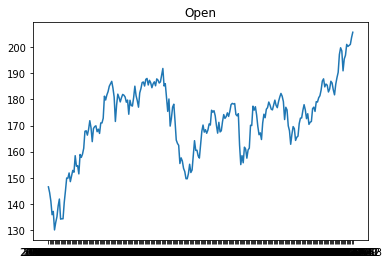

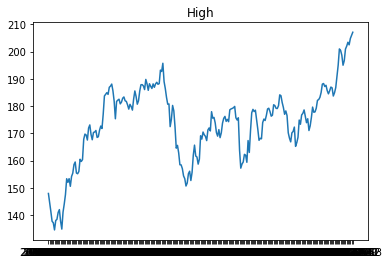

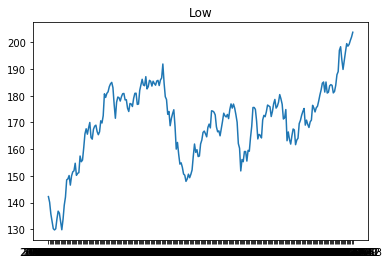

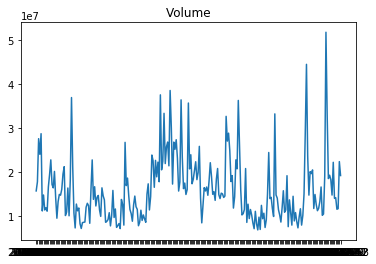

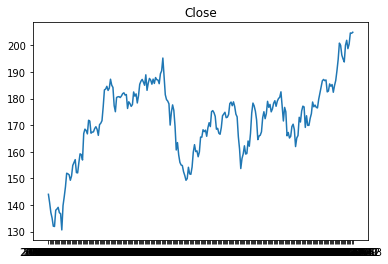

In [0]:
import matplotlib.pyplot as plt 

plt.plot(stock_data['Open'])
plt.title('Open')
plt.show()
plt.plot(stock_data['High'])
plt.title('High')
plt.show()
plt.plot(stock_data['Low'])
plt.title('Low')
plt.show()
plt.plot(stock_data['Volume'])
plt.title('Volume')
plt.show()
plt.plot(stock_data['Close'])
plt.title('Close')
plt.show()

Visualize the graphs

In [0]:
times = sorted(stock_data.index.values)

Sort the data by order of the index => sequential

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(stock_data, train_size=0.9, test_size=0.1, shuffle=False)

Split data into train and test

In [0]:
v = df_train.loc[:].values
min_max_scaler = MinMaxScaler()
df_train = min_max_scaler.fit_transform(v)
df_test = min_max_scaler.transform(df_test.loc[:].values)

scales the data between 0 and 1

In [0]:
import numpy as np
from collections import deque

def time_series(arr):
  limit = 10
  sequential_data = []
  prev_days = deque(maxlen=limit)
  for i in arr:
    prev_days.append([n for n in i[:-1]]) # store all but the labels
    if len(prev_days) == limit:
      sequential_data.append([np.array(prev_days), i[-1]]) # append the labels
  return sequential_data

Add timestamp to the data since a recurrent network takes 3 dimensions

In [0]:
df_train = time_series(df_train)
df_test = time_series(df_test)

X_train = []
y_train = []
X_test = []
y_test = []

for feature, label in df_train:
  X_train.append(feature)
  y_train.append(label)
for feature, label in df_test:
  X_test.append(feature)
  y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Further split the training and testing dataset into X_train, y_train, X_test, y_test

In [0]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, CuDNNLSTM, Dropout, BatchNormalization 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

Constructs the RNN, I am using CuDNNLSTM for a faster performance

In [0]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(X_train.shape[1:])))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=10)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['mse', 'mae'])
model.fit(X_train, y_train, epochs=300, batch_size=12, callbacks=[early_stop])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 216 samples
Epoch 1/300
216/216 [==============================] - 3s 16ms/sample - loss: 0.0610 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1999
Epoch 2/300
216/216 [==============================] - 0s 546us/sample - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1674
Epoch 3/300
216/216 [==============================] - 0s 526us/sample - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1612
Epoch 4/300
216/216 [==============================] - 0s 526us/sample - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1552
Epoch 5/300
216/216 [==============================] - 0s 556us/sample - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1573
Epoch 6/300
216/216 [==============================] - 0s 558us/sample - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1501
Epoch 7/300
216/216 [========

Construct the neural network for our stock prediction

In [0]:
model.evaluate(X_test, y_test)
pred = model.predict(X_test)
plt.plot(pred, 'r')
plt.plot(y_test, 'b')
plt.title('Stock Prediction')
plt.legend(['Predicted', 'Actual'])
plt.show()